### @bryandlee

In [ ]:
# !pip install ipympl

### Pre-Trained Generator

[StyleGAN2 generator loaded] ./checkpoint/550000.pt

sample images:


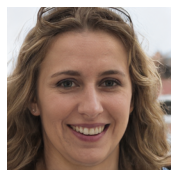

In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

def tensor2image(tensor):
    tensor = tensor.clamp_(-1., 1.).detach().squeeze().permute(1,2,0).cpu().numpy()
    return tensor*0.5 + 0.5

def imshow(img, size=5, cmap='jet'):
    %matplotlib inline
    plt.figure(figsize=(size,size))
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def horizontal_concat(imgs):
    return torch.cat([img.unsqueeze(0) for img in imgs], 3) 

device = 'cuda:0'
image_size = 256
n_samples = 1

generator_path = './checkpoint/550000.pt'
latent_dim = 512
truncation = 0.7

imshow_size = 3

from stylegan2 import Generator

generator = Generator(image_size, latent_dim, 8)
generator_ckpt = torch.load(generator_path, map_location='cpu')
generator.load_state_dict(generator_ckpt["g_ema"], strict=False)
generator.eval().to(device)

print(f'[StyleGAN2 generator loaded] {generator_path}\n')

with torch.no_grad():
    trunc_mean = generator.mean_latent(4096).detach().clone()
    latent = generator.get_latent(torch.randn(n_samples, latent_dim, device=device))
    imgs_gen, features = generator([latent],
                                   truncation=truncation,
                                   truncation_latent=trunc_mean,
                                   input_is_latent=True,
                                   randomize_noise=True)
    torch.cuda.empty_cache()

print("sample images:")
imshow(tensor2image(horizontal_concat(imgs_gen)), size=imshow_size*n_samples)

### Few-Shot Labelling with a Simple Interface

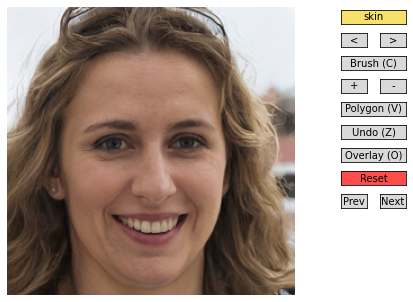

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import widgets
from matplotlib.colors import hsv_to_rgb

import random
import copy
import cv2

class Labeller:
    def __init__(self, images, classes):
        
        self.n_image = len(images)
        self.img_idx = 0

        self.images = images        
        self._reset_label()
        
        self.classes = classes
        self.n_class = len(classes)
        self.colors = self._sample_colors(self.n_class)
        self.colors[0] = np.array([1., 1., 1.])
        self._class = 1

        self.fig = plt.figure('Simple Labeller')
        self.ax = self.fig.add_subplot()
        self.fig.subplots_adjust(left=0.0, bottom=0.0, right=0.80, top=1.0)

        self.ax.axis('off')
        self.ax_img = self.ax.imshow(self.images[self.img_idx])
        
        self._add_buttons()        
        self.fig.canvas.mpl_connect('key_press_event', self._key_maps)

        self.show_overlay = True
        self.history = []
        self.brush_size = 1
        
        plt.show()
       
    def _sample_colors(self, n=1):
        h = np.linspace(0.0, 1.0, n)[:,np.newaxis]
        s = np.random.uniform(0.5, 0.6, (n,1))
        v = np.random.uniform(0.8, 1.0, (n,1))
        return hsv_to_rgb(np.concatenate([h,s,v], axis=1))

    def _draw(self, image):
        self.ax_img.set_data(image)
        
    def _key_maps(self, event):
        key_maps = {
            'c': self._lasso,
            'v': self._poly,
            'z': self._undo,
            'right': self._next_class,
            'left': self._prev_class,
            'o': self._overlay,
            'up': self._brush_up,
            'down': self._brush_down,
        }
        key = event.key.lower()
        if key in key_maps:
            key_maps[key](None)
        
        
    def _add_buttons(self):
        axes_coords = [0.84, 0.94, 0.15, 0.05]
        interval = 0.08

        self.class_box = widgets.Button(plt.axes(axes_coords),
                                        self.classes[self._class],
                                        color=self.colors[self._class],
                                        hovercolor=self.colors[self._class])

        axes_coords[1] -= interval
        axes_coords_split = copy.deepcopy(axes_coords)
        axes_coords_split[2] = 0.06
        self.prev_class = widgets.Button(plt.axes(axes_coords_split), '<')
        self.cid_prev_class = self.prev_class.on_clicked(self._prev_class)
        axes_coords_split[0] = 0.84 + 0.15 - 0.06
        self.next_class = widgets.Button(plt.axes(axes_coords_split), '>')
        self.cid_next_class = self.next_class.on_clicked(self._next_class)
        
        axes_coords[1] -= interval
        self.lasso = widgets.Button(plt.axes(axes_coords), 'Brush (C)')
        self.cid_lasso = self.lasso.on_clicked(self._lasso)

        axes_coords[1] -= interval
        axes_coords_split = copy.deepcopy(axes_coords)
        axes_coords_split[2] = 0.06
        self.brush_up = widgets.Button(plt.axes(axes_coords_split), '+')
        self.cid_brush_up = self.brush_up.on_clicked(self._brush_up)
        axes_coords_split[0] = 0.84 + 0.15 - 0.06
        self.brush_down = widgets.Button(plt.axes(axes_coords_split), '-')
        self.cid_brush_down = self.brush_down.on_clicked(self._brush_down)
        
        axes_coords[1] -= interval
        self.poly = widgets.Button(plt.axes(axes_coords), 'Polygon (V)')
        self.cid_poly = self.poly.on_clicked(self._poly)
        
        axes_coords[1] -= interval
        self.undo = widgets.Button(plt.axes(axes_coords), 'Undo (Z)')
        self.cid_undo = self.undo.on_clicked(self._undo)

        axes_coords[1] -= interval
        self.overlay = widgets.Button(plt.axes(axes_coords), 'Overlay (O)')
        self.cid_overlay = self.overlay.on_clicked(self._overlay)
        
        axes_coords[1] -= interval
        self.reset = widgets.Button(plt.axes(axes_coords), 'Reset',
                                    color=[1, 0.3, 0.3], hovercolor=[1, 0.5, 0.5])
        self.cid_reset = self.reset.on_clicked(self._reset)
        
        axes_coords[1] -= interval
        axes_coords_split = copy.deepcopy(axes_coords)
        axes_coords_split[2] = 0.06
        self.prev_img = widgets.Button(plt.axes(axes_coords_split), 'Prev')
        self.cid_prev_img = self.prev_img.on_clicked(self._prev_img)
        axes_coords_split[0] = 0.84 + 0.15 - 0.06
        self.next_img = widgets.Button(plt.axes(axes_coords_split), 'Next')
        self.cid_next_img = self.next_img.on_clicked(self._next_img)
        
    def _next_class(self, event):
        self._class = (self._class + 1) % self.n_class
        self._update_class_box()
        
    def _prev_class(self, event):
        self._class = (self._class - 1) % self.n_class
        self._update_class_box()

    def _update_class_box(self):
        self.class_box.label.set_text(self.classes[self._class])
        self.class_box.color = self.colors[self._class]
        self.class_box.hovercolor = self.class_box.color
        self.fig.canvas.draw()
        
    def _undo(self, event):
        if len(self.history) > 0:
            self.history.pop(-1)
            self._reset_label(only_current_img=True)
            for inputs in self.history:
                self._update_label(inputs)
            self._draw(self.get_image_label_overlay())

    def _overlay(self, event):
        self.show_overlay = not self.show_overlay
        if self.show_overlay:
            self._draw(self.get_image_label_overlay())
        else:
            self._draw(self.images[self.img_idx])
    
    def _reset(self, event):
        self.history = []
        self._reset_label(only_current_img=True)
        self._draw(self.images[self.img_idx])

    def _next_img(self, event):
        self.img_idx = (self.img_idx + 1) % self.n_image
        self._on_img_change()

    def _prev_img(self, event):
        self.img_idx = (self.img_idx - 1) % self.n_image
        self._on_img_change()

    def _on_img_change(self):
        self.history = []
        self.show_overlay = True        
        self._draw(self.get_image_label_overlay())
        
    def _poly(self, event):
        self._reset_selectors()
        self.poly_selector = widgets.PolygonSelector(self.ax, self._process_polygon)
    
    def _process_polygon(self, vert):
        polygon = np.array(vert, np.int32).reshape((-1, 1, 2))
        inputs = ('poly', polygon, self._class)
        self.history.append(inputs)
        self._update_label(inputs)
        self._after_new_label()
        self._reset_selectors()

    def _brush_up(self, dummy):
        self.brush_size += 1
        
    def _brush_down(self, dummy):
        self.brush_size = max(self.brush_size-1, 1)
        
    def _lasso(self, event):
        self._reset_selectors()        
        self.lasso_selector = widgets.LassoSelector(
            self.ax, self._process_lasso, lineprops=dict(linewidth=self.brush_size//2)
        )
    
    def _process_lasso(self, vert):
        path = np.array(vert, np.int32).reshape((-1, 1, 2))
        path = np.unique(path, axis=1)
        inputs = ('lasso', path, self._class, self.brush_size)
        self.history.append(inputs)
        self._update_label(inputs)
        self._after_new_label()
        self._reset_selectors()

    def _reset_selectors(self):
        if hasattr(self, 'lasso_selector'):
            self.lasso_selector.set_visible(False)
            del(self.lasso_selector)
        if hasattr(self, 'poly_selector'):
            self.poly_selector.set_visible(False)            
            del(self.poly_selector)
    
    def _after_new_label(self):
        self.show_overlay = True
        self._draw(self.get_image_label_overlay())
            
    def _reset_label(self, only_current_img=False):
        if only_current_img:
            self.labels[self.img_idx] = np.zeros(
                (self.images.shape[1], self.images.shape[2]),
                np.uint8
            )
        else:
            self.labels = np.zeros(
                (self.n_image, self.images.shape[1], self.images.shape[2]),
                np.uint8
            )
        
    def _update_label(self, inputs):
        if inputs[0] == 'poly':
            self.labels[self.img_idx] = cv2.fillPoly(
                self.labels[self.img_idx], [inputs[1]], inputs[2], 0
            )
        elif inputs[0] == 'lasso':
            self.labels[self.img_idx] = cv2.polylines(
                self.labels[self.img_idx], [inputs[1]], isClosed=False,
                color=inputs[2], thickness=inputs[3]
            )
        
    def get_image_label_overlay(self):
        overlay = self.images[self.img_idx].copy()
        label_image = self.get_visualized_label()
        non_zeros = label_image > 0
        overlay[non_zeros] = label_image[non_zeros]
        return overlay
        
    def get_visualized_label(self, label=None):
        if label is None:
            label = self.labels[self.img_idx]
        
        label_image = np.zeros_like(self.images[self.img_idx])
        for c in range(1,self.n_class):
            label_image[label == c] = self.colors[c]
        return label_image
    
    def get_labels(self):
        return self.labels

classes = ['background', 'skin', 'hair', 'eye', 'eyebrow', 'nose', 'mouth', 'ear']
        
imgs_gen = imgs_gen.clamp_(-1., 1.).detach().permute(0,2,3,1).cpu().numpy() * 0.5 + 0.5
labeller = Labeller(imgs_gen, classes)

### Train

In [4]:
from torch import nn
import torch.nn.functional as F
import time

def ConvLReLU(in_ch, out_ch, kernel_size, dilation):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding=dilation, dilation=dilation),
        nn.LeakyReLU(inplace=True)
    )

class CNN(nn.Module):
    def __init__(self, in_ch, n_class):
        super().__init__()
        dilations = [1, 2, 1, 2, 1]
        channels = [in_ch, 128, 64, 64, 32, n_class]
        
        layers = []
        for d, c_in, c_out in zip(dilations, channels[:-1], channels[1:]):
            layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, padding=d, dilation=d))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.layers = nn.Sequential(*layers[:-1])
        
    def forward(self, x):
        return self.layers(x)

@torch.no_grad()
def concat_features(features):
    h = max([f.shape[-2] for f in features])
    w = max([f.shape[-1] for f in features])
    return torch.cat([nn.functional.interpolate(f, (h,w), mode='nearest') for f in features], dim=1)


data = dict(
    latents=latent.cpu(),
    features=concat_features(features).cpu(),
    labels=torch.tensor(labeller.get_labels()).long(),
)  
    
net = CNN(data['features'].shape[1], len(classes))
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

net.train().to(device)
start_time = time.time()
for epoch in range(1, 100+1):
    sample_order = list(range(n_samples))
    random.shuffle(sample_order)

    for idx in sample_order:
        
        sample = data['features'][idx].unsqueeze(0).to(device)
        label = data['labels'][idx].unsqueeze(0).to(device)

        out = net(sample)
        
        loss = F.cross_entropy(out, label, reduction='mean')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 50 == 0:
        print(f'{epoch:5}-th epoch | loss: {loss.item():6.4f} | time: {time.time()-start_time:6.1f}sec')

    scheduler.step()

   50-th epoch | loss: 0.0336 | time:   21.5sec
  100-th epoch | loss: 0.0297 | time:   42.8sec


### Test

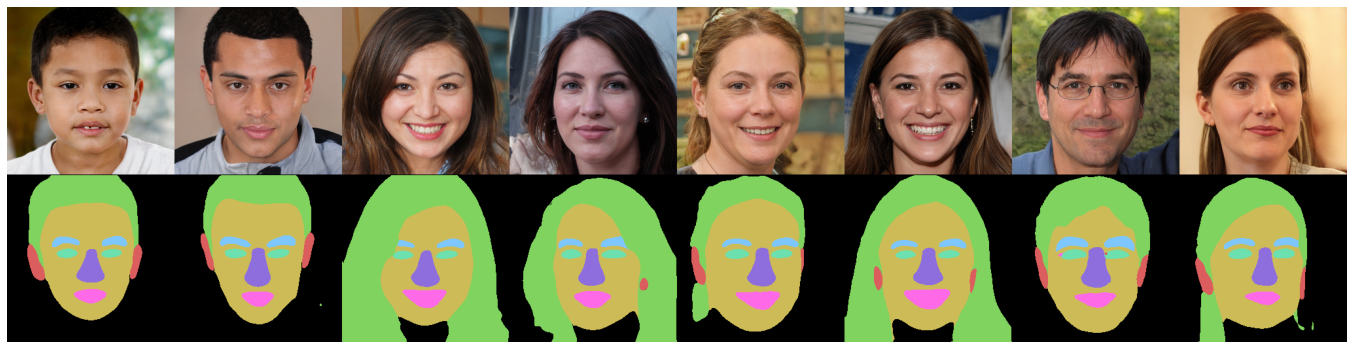

In [11]:
device = 'cpu'

n_test = 8

generator.eval().to(device)
net.eval().to(device)
with torch.no_grad():
    latent = generator.get_latent(torch.randn(n_test, latent_dim, device=device))
    imgs_gen, features = generator([latent],
                                   truncation=truncation,
                                   truncation_latent=trunc_mean.to(device),
                                   input_is_latent=True,
                                   randomize_noise=True)

    torch.cuda.empty_cache()
    out = net(concat_features(features))
    predictions = out.data.max(1)[1].cpu().numpy()

    # visualize
    predictions = np.concatenate([labeller.get_visualized_label(pred) for pred in predictions], axis=1)
    results = np.concatenate([tensor2image(horizontal_concat(imgs_gen)), predictions], axis=0)

    imshow(results, size=imshow_size*n_test)